## ⚡ Before you start

Let's make sure that we have access to GPU. We can use `nvidia-smi` command to do that. In case of any problems navigate to `Edit` -> `Notebook settings` -> `Hardware accelerator`, set it to `GPU`, and then click `Save`.

In [1]:
!nvidia-smi

Mon Jan 15 10:58:03 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 546.12                 Driver Version: 546.12       CUDA Version: 12.3     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                     TCC/WDDM  | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce GTX 1660 Ti   WDDM  | 00000000:01:00.0  On |                  N/A |
| N/A   50C    P8              11W /  80W |   5851MiB /  6144MiB |     24%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

## 🧪 Install autodistill

**NOTE:** Autodistill is an ecosystem for using big, slower foundation models to train small, faster supervised models. Each Base, as well as the Target model, has its own separate repository and pip package.

In [2]:
!pip install -q \
autodistill \
autodistill-grounded-sam \
autodistill-yolov8 \
roboflow \
supervision==0.9.0

**NOTE:** To make it easier for us to manage datasets, images and models we create a `HOME` constant.

In [1]:
import os
HOME = os.getcwd()
print(HOME)

d:\auto


## 🖼️ Image dataset preperation

**NOTE:** To use Autodistill all you need to have is a folder of images that you want to automatically annotate, and use for target model training.

In [4]:
!mkdir {HOME}/images

���� ������ �ùٸ��� �ʽ��ϴ�.


In [5]:
# import roboflow

# roboflow.login()

# dataset = roboflow.download_dataset(dataset_url="https://universe.roboflow.com/mohamed-traore-2ekkp/taco-trash-annotations-in-context/model/16", model_format="yolov8")

Once you have downloaded your dataset, move all of the images from the `train` set in your downloaded dataset into the `images/` directory we created earlier:

In [6]:
# %mv {HOME}/<dataset-name>/train/* {HOME}/images

Now we are ready to start using Autodistill!

### Download raw videos

**NOTE:** In this tutorial, we will start with a directory containing video files and I will show you how to turn it into a ready-to-use collection of images. If you are working with your images, you can skip this part.

### Convert videos into images

**NOTE:** Now, let's convert videos into images. By default, the code below saves every `10th` frame from each video. You can change this by manipulating the value of the `FRAME_STRIDE` parameter.

In [8]:
VIDEO_DIR_PATH = f"{HOME}/videos"
IMAGE_DIR_PATH = f"{HOME}/images"
FRAME_STRIDE = 10

**NOTE:** Notice that we put two of our videos aside so that we can use them at the end of the notebook to evaluate our model.

In [9]:
import supervision as sv
from tqdm.notebook import tqdm

video_paths = sv.list_files_with_extensions(
    directory=VIDEO_DIR_PATH,
    extensions=["mov", "mp4"])

TEST_VIDEO_PATHS, TRAIN_VIDEO_PATHS = video_paths[:2], video_paths[2:]

for video_path in tqdm(TRAIN_VIDEO_PATHS):
    video_name = video_path.stem
    image_name_pattern = video_name + "-{:05d}.png"
    with sv.ImageSink(target_dir_path=IMAGE_DIR_PATH, image_name_pattern=image_name_pattern) as sink:
        for image in sv.get_video_frames_generator(source_path=str(video_path), stride=FRAME_STRIDE):
            sink.save_image(image=image)

  0%|          | 0/1 [00:00<?, ?it/s]

### Display image sample

**NOTE:** Before we start building a model with autodistill, let's make sure we have everything we need.

In [10]:
import supervision as sv

image_paths = sv.list_files_with_extensions(
    directory=IMAGE_DIR_PATH,
    extensions=["png", "jpg", "jpg"])

print('image count:', len(image_paths))

image count: 181


**NOTE:** We can also plot sample of our image dataset.

In [11]:
IMAGE_DIR_PATH = f"{HOME}/images"
SAMPLE_SIZE = 16
SAMPLE_GRID_SIZE = (4, 4)
SAMPLE_PLOT_SIZE = (16, 16)

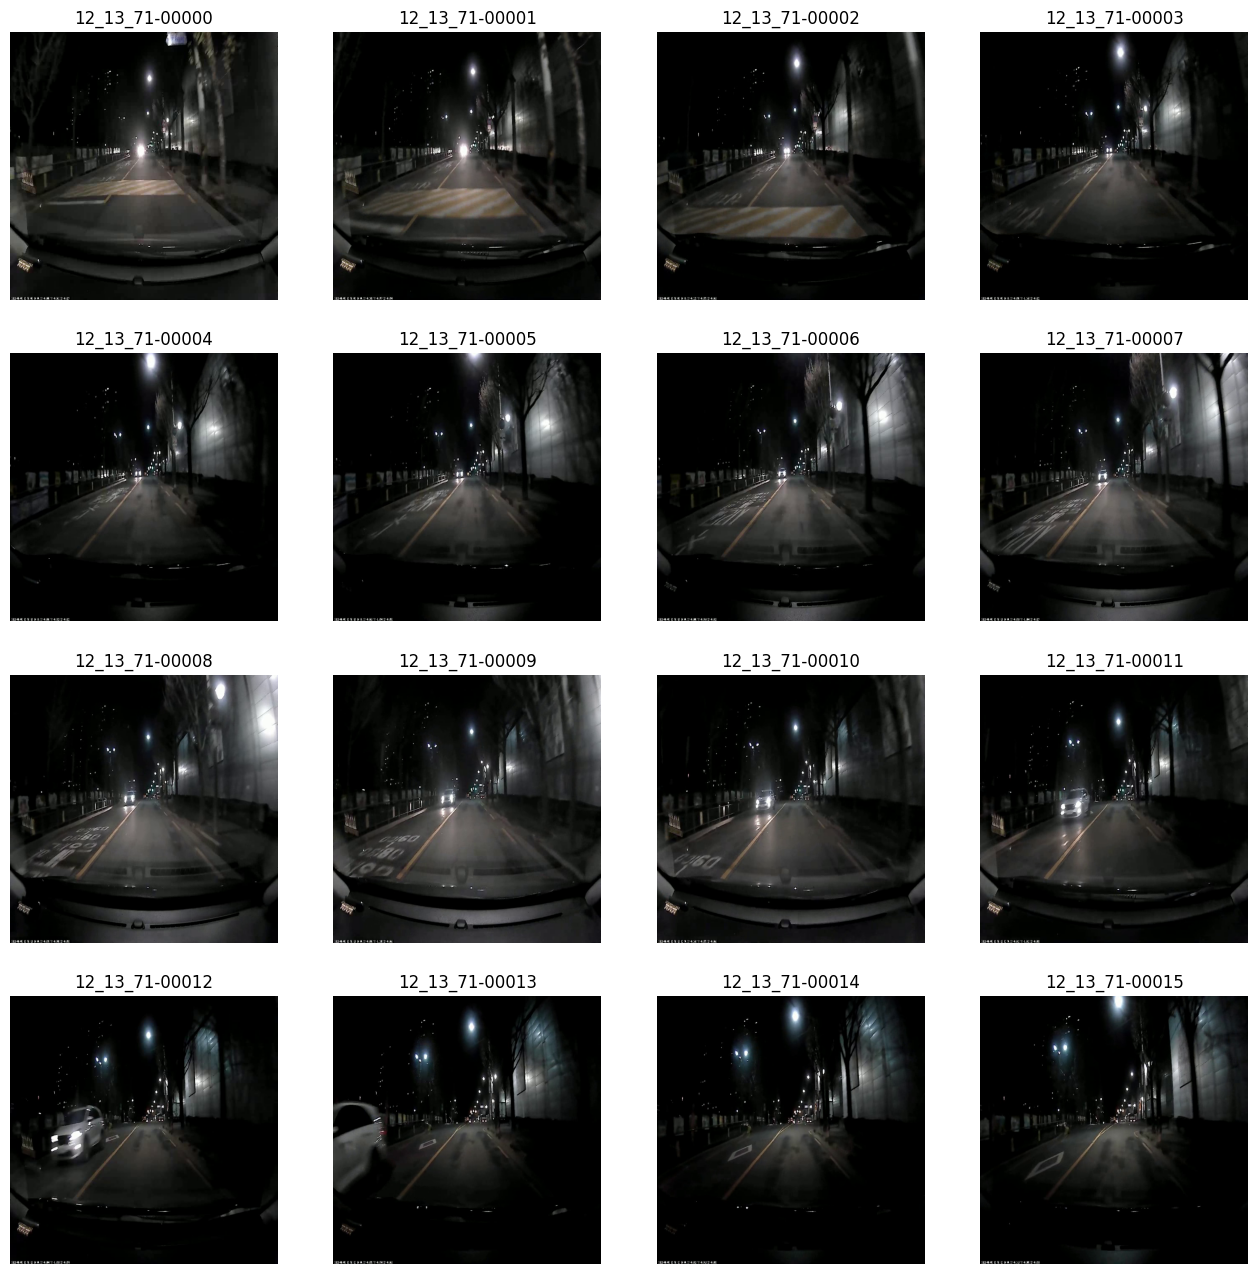

In [12]:
import cv2
import supervision as sv

titles = [
    image_path.stem
    for image_path
    in image_paths[:SAMPLE_SIZE]]
images = [
    cv2.imread(str(image_path))
    for image_path
    in image_paths[:SAMPLE_SIZE]]

sv.plot_images_grid(images=images, titles=titles, grid_size=SAMPLE_GRID_SIZE, size=SAMPLE_PLOT_SIZE)

In [13]:
import torch

# GPU 사용 여부 확인
if torch.cuda.is_available():
    print("GPU 사용 가능")
else:
    print("GPU 사용 불가능")

GPU 사용 가능


In [14]:
import tensorflow as tf

# GPU 사용 여부 확인
if tf.config.list_physical_devices("GPU"):
    print("GPU 사용 가능")
else:
    print("GPU 사용 불가능")


GPU 사용 불가능


## 🏷️ Autolabel dataset

### Define ontology

**Ontology** - an Ontology defines how your Base Model is prompted, what your Dataset will describe, and what your Target Model will predict. A simple Ontology is the CaptionOntology which prompts a Base Model with text captions and maps them to class names. Other Ontologies may, for instance, use a CLIP vector or example images instead of a text caption.

In [18]:
from autodistill.detection import CaptionOntology

ontology=CaptionOntology({
    "car": "car",
    "person": "human"
})

### Initiate base model and autolabel

**Base Model** - A Base Model is a large foundation model that knows a lot about a lot. Base models are often multimodal and can perform many tasks. They're large, slow, and expensive. Examples of Base Models are GroundedSAM and GPT-4's upcoming multimodal variant. We use a Base Model (along with unlabeled input data and an Ontology) to create a Dataset.

In [19]:
DATASET_DIR_PATH = f"{HOME}/dataset"

**NOTE:** Base Models are slow... Make yourself a coffee, autolabeing may take a while. ☕

In [20]:
from autodistill_grounded_sam import GroundedSAM

base_model = GroundedSAM(ontology=ontology)
dataset = base_model.label(
    input_folder=IMAGE_DIR_PATH,
    extension=".png",
    output_folder=DATASET_DIR_PATH)

trying to load grounding dino directly
final text_encoder_type: bert-base-uncased


Labeling d:\autolabeling/images\12_13_71-00002.png:   1%|          | 2/181 [08:34<12:45:38, 256.64s/it]

### Display dataset sample

**Dataset** - a Dataset is a set of auto-labeled data that can be used to train a Target Model. It is the output generated by a Base Model.

In [ ]:
ANNOTATIONS_DIRECTORY_PATH = f"{HOME}/dataset/train/labels"
IMAGES_DIRECTORY_PATH = f"{HOME}/dataset/train/images"
DATA_YAML_PATH = f"{HOME}/dataset/data.yaml"

In [ ]:
import supervision as sv

dataset = sv.DetectionDataset.from_yolo(
    images_directory_path=IMAGES_DIRECTORY_PATH,
    annotations_directory_path=ANNOTATIONS_DIRECTORY_PATH,
    data_yaml_path=DATA_YAML_PATH)

len(dataset)

0

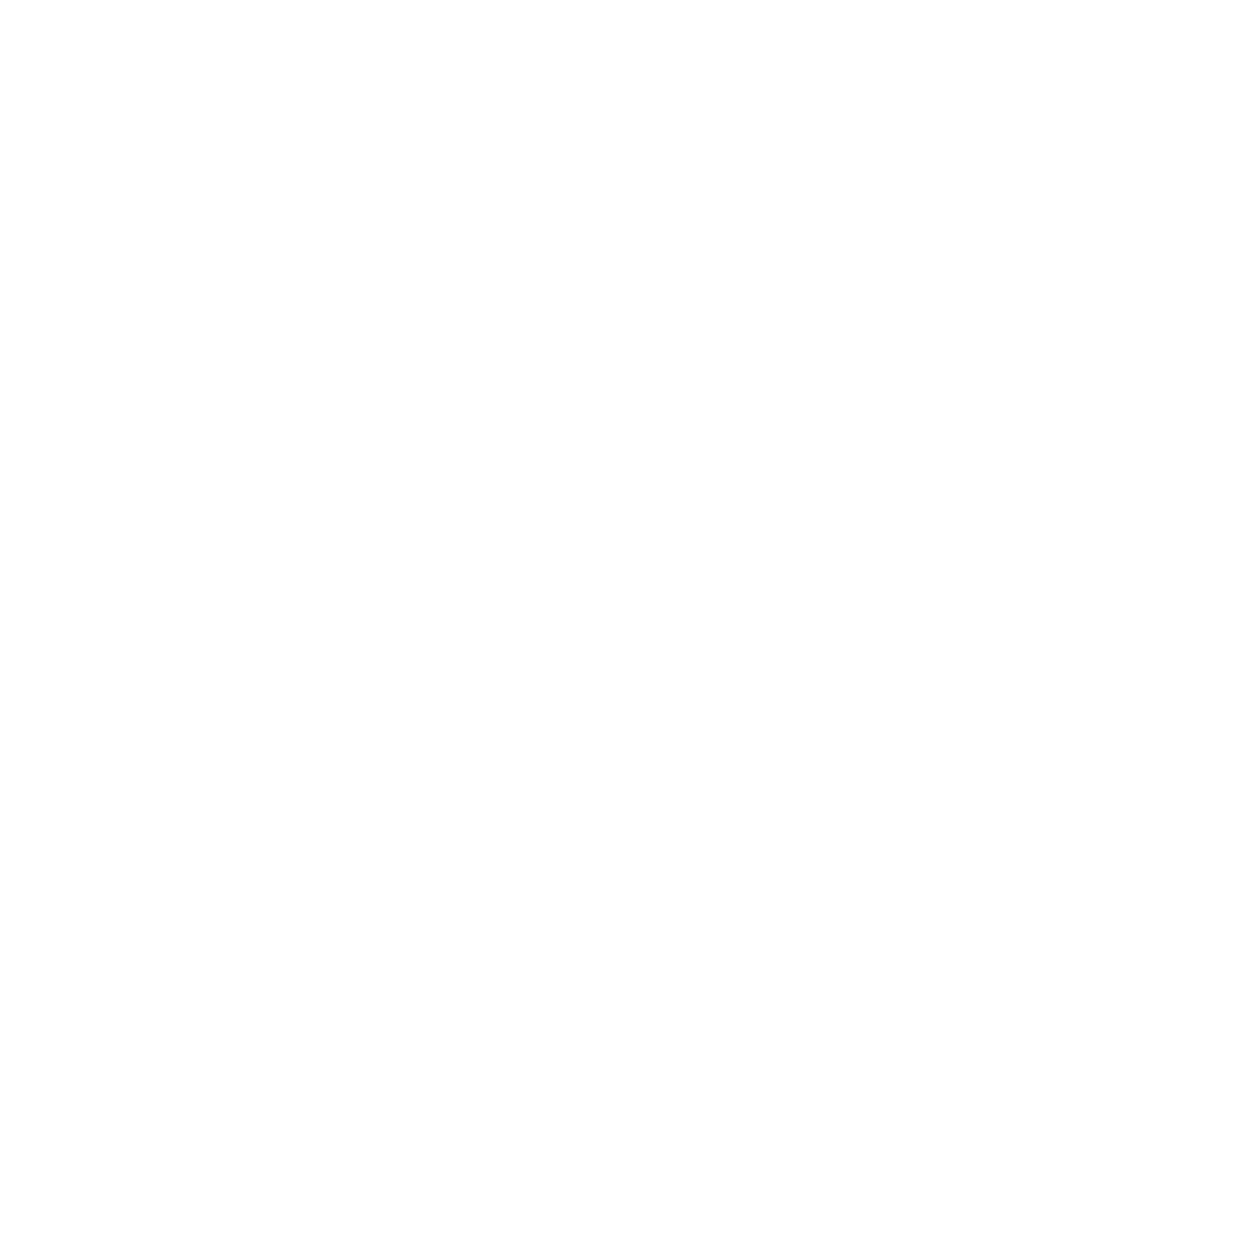

In [ ]:
import supervision as sv

image_names = list(dataset.images.keys())[:SAMPLE_SIZE]

mask_annotator = sv.MaskAnnotator()
box_annotator = sv.BoxAnnotator()

images = []
for image_name in image_names:
    image = dataset.images[image_name]
    annotations = dataset.annotations[image_name]
    labels = [
        dataset.classes[class_id]
        for class_id
        in annotations.class_id]
    annotates_image = mask_annotator.annotate(
        scene=image.copy(),
        detections=annotations)
    annotates_image = box_annotator.annotate(
        scene=annotates_image,
        detections=annotations,
        labels=labels)
    images.append(annotates_image)

sv.plot_images_grid(
    images=images,
    titles=image_names,
    grid_size=SAMPLE_GRID_SIZE,
    size=SAMPLE_PLOT_SIZE)

## 🔥 Train target model - YOLOv8

**Target Model** - a Target Model is a supervised model that consumes a Dataset and outputs a distilled model that is ready for deployment. Target Models are usually small, fast, and fine-tuned to perform a specific task very well (but they don't generalize well beyond the information described in their Dataset). Examples of Target Models are YOLOv8 and DETR.

In [ ]:
%cd {HOME}

from autodistill_yolov8 import YOLOv8

target_model = YOLOv8("yolov8n.pt")
target_model.train(DATA_YAML_PATH, epochs=50)

using dhist requires you to install the `pickleshare` library.


d:\autolabeling


New https://pypi.org/project/ultralytics/8.0.230 available  Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.81  Python-3.10.13 torch-1.12.1+cu116 CPU
yolo\engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=d:\autolabeling/dataset/data.yaml, epochs=50, patience=50, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=cpu, workers=8, project=None, name=None, exist_ok=False, pretrained=False, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, image_weights=False, rect=False, cos_lr=False, close_mosaic=0, resume=False, amp=True, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, line_thickness=3, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, boxes

FileNotFoundError: [34m[1mtrain: [0mError loading data from D:\autolabeling\dataset\train\images
See https://github.com/ultralytics/yolov5/wiki/Train-Custom-Data

In [ ]:
!ls {HOME}/runs/detect/train/

: 

## ⚖️ Evaluate target model

**NOTE:** As with the regular YOLOv8 training, we can now take a look at artifacts stored in `runs` directory.

In [ ]:
%cd {HOME}

from IPython.display import Image

Image(filename=f'{HOME}/runs/detect/train/confusion_matrix.png', width=600)

: 

In [ ]:
%cd {HOME}

from IPython.display import Image

Image(filename=f'{HOME}/runs/detect/train/results.png', width=600)

: 

In [ ]:
%cd {HOME}

from IPython.display import Image

Image(filename=f'{HOME}/runs/detect/train/val_batch0_pred.jpg', width=600)

: 

## 🎬 Run Inference on a video

In [ ]:
INPUT_VIDEO_PATH = TEST_VIDEO_PATHS[0]
OUTPUT_VIDEO_PATH = f"{HOME}/output.mp4"
TRAINED_MODEL_PATH = f"{HOME}/runs/detect/train/weights/best.pt"

: 

In [ ]:
!yolo predict model={TRAINED_MODEL_PATH} source={INPUT_VIDEO_PATH}

: 

## Upload dataset and model to Roboflow

comming soon...

  # 🏆 Congratulations

### Learning Resources

Roboflow has produced many resources that you may find interesting as you advance your knowledge of computer vision:

- [Roboflow Notebooks](https://github.com/roboflow/notebooks): A repository of over 20 notebooks that walk through how to train custom models with a range of model types, from YOLOv7 to SegFormer.
- [Roboflow YouTube](https://www.youtube.com/c/Roboflow): Our library of videos featuring deep dives into the latest in computer vision, detailed tutorials that accompany our notebooks, and more.
- [Roboflow Discuss](https://discuss.roboflow.com/): Have a question about how to do something on Roboflow? Ask your question on our discussion forum.
- [Roboflow Models](https://roboflow.com): Learn about state-of-the-art models and their performance. Find links and tutorials to guide your learning.

### Convert data formats

Roboflow provides free utilities to convert data between dozens of popular computer vision formats. Check out [Roboflow Formats](https://roboflow.com/formats) to find tutorials on how to convert data between formats in a few clicks.

### Connect computer vision to your project logic

[Roboflow Templates](https://roboflow.com/templates) is a public gallery of code snippets that you can use to connect computer vision to your project logic. Code snippets range from sending emails after inference to measuring object distance between detections.